<a href="https://colab.research.google.com/github/0jayer/Autonomous_Robot_Simulations/blob/main/KinodynamicMotionPlanning_with_PRM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

# Define the grid size and resolution
grid_size = (11, 11)  # 11x11 grid cells
grid = np.zeros(grid_size)  # Initialize grid with free space (0)

# Define obstacles
obstacles = [
    (2, 3, 1, 4),  # (x_start, x_end, y_start, y_end)
    (5, 6, 5, 7),
    (5, 9, 5, 6),
    (8, 9, 2, 3),
]

# Place obstacles on the grid
for (x_start, x_end, y_start, y_end) in obstacles:
    grid[x_start:x_end, y_start:y_end] = 1  # Set obstacle cells to 1

In [3]:
def heuristic(a, b):
    # Calculate the Euclidean distance between points a and b
    return np.linalg.norm(np.array(a) - np.array(b))

def is_collision_free(node, grid):
    x, y = node
    if x < 0 or x >= grid.shape[0] or y < 0 or y >= grid.shape[1]:
        return False
    if grid[x, y] == 1:
        return False
    return True

In [4]:
def prm(start, goal, grid, num_samples=1000, k=50):
    samples = [start, goal]
    while len(samples) < num_samples + 2:
        sample = (np.random.randint(0, grid.shape[0]), np.random.randint(0, grid.shape[1]))
        if is_collision_free(sample, grid):
            samples.append(sample)

    graph = {sample: [] for sample in samples}

    for sample in samples:
        distances = [(heuristic(sample, other), other) for other in samples if other != sample]
        distances.sort()
        for _, neighbor in distances[:k]:
            if is_collision_free(neighbor, grid) and is_collision_free(sample, grid):
                graph[sample].append(neighbor)
                graph[neighbor].append(sample)

    def a_star(start, goal, graph):
        open_heap = []
        heapq.heappush(open_heap, (0 + heuristic(start, goal), 0, start))
        came_from = {start: None}
        g_score = {start: 0}

        while open_heap:
            _, current_cost, current = heapq.heappop(open_heap)

            if current == goal:
                path = []
                while current:
                    path.append(current)
                    current = came_from[current]
                return path[::-1]

            for neighbor in graph[current]:
                tentative_g_score = current_cost + heuristic(current, neighbor)
                if tentative_g_score < g_score.get(neighbor, float('inf')):
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score = tentative_g_score + heuristic(neighbor, goal)
                    heapq.heappush(open_heap, (f_score, tentative_g_score, neighbor))

        return False

    return a_star(start, goal, graph)


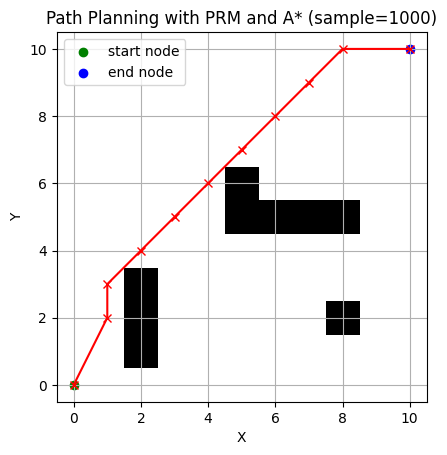

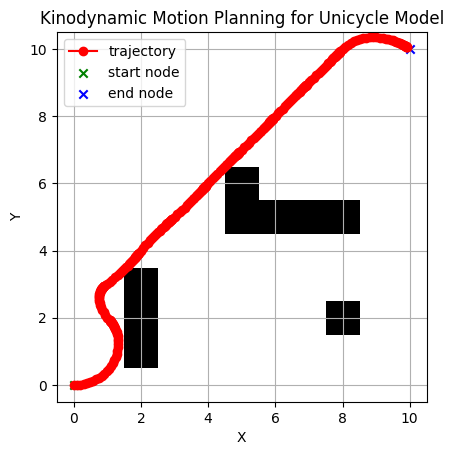

In [5]:
# Define start and goal positions
start = (0, 0)
goal = (10, 10)

# Find path using PRM algorithm
path = prm(start, goal, grid)

if not path:
    print("Path not found")
else:
    # Extract waypoints from the path
    waypoints = path

    # Initialize arrays for the trajectory
    x, y = zip(*waypoints)

    # Plot the grid with the path
    plt.imshow(grid.T, cmap='Greys', origin='lower')
    plt.plot(*zip(*path), marker='x', color='red')
    plt.scatter(start[0], start[1], marker='o', color='green', label='start node')
    plt.scatter(goal[0], goal[1], marker='o', color='blue', label='end node')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Path Planning with PRM and A* (sample=1000)')
    plt.legend()
    plt.grid()
    plt.show()

    # Unicycle model motion planning
    def unicycle_model(state, v, omega, dt):
        x, y, theta = state
        x += v * np.cos(theta) * dt
        y += v * np.sin(theta) * dt
        theta += omega * dt
        return x, y, theta

    def kinodynamic_control_to_waypoint(state, waypoint, dt):
        x, y, theta = state
        x_goal, y_goal = waypoint

        # Proportional control law for unicycle model
        k_rho = 1.0
        k_alpha = 2.0

        rho = np.sqrt((x_goal - x)**2 + (y_goal - y)**2)
        alpha = np.arctan2(y_goal - y, x_goal - x) - theta

        v = k_rho * rho
        omega = k_alpha * alpha

        # Saturate v and omega to respect unicycle model limits
        v = np.clip(v, -1.0, 1.0)
        omega = np.clip(omega, -np.pi/4, np.pi/4)

        return v, omega

    # Simulation parameters
    dt = 0.1  # Time step
    state = (start[0], start[1], 0)  # Initial state (x, y, theta)
    trajectory = [state]

    for waypoint in waypoints[1:]:
        while True:
            v, omega = kinodynamic_control_to_waypoint(state, waypoint, dt)
            state = unicycle_model(state, v, omega, dt)
            trajectory.append(state)

            if np.linalg.norm(np.array(state[:2]) - np.array(waypoint)) < 0.1:
                break

    # Extract the trajectory for plotting
    traj_x, traj_y, _ = zip(*trajectory)

    # Plot the trajectory on the grid
    plt.imshow(grid.T, cmap='Greys', origin='lower')
    plt.plot(traj_x, traj_y, marker='o', color='red', label='trajectory')
    plt.scatter(start[0], start[1], marker='x', color='green', label='start node')
    plt.scatter(goal[0], goal[1], marker='x', color='blue', label='end node')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Kinodynamic Motion Planning for Unicycle Model')
    plt.legend()
    plt.grid()
    plt.show()


